In [1]:
import pandas as pd

import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
%load_ext autoreload
%autoreload 2

In [12]:
df = pd.read_excel('GFR-SVR数据.xls')
df.shape

(1197, 6)

In [13]:
df.columns = ['id', 'age', 'sex', 'rGFR', 'Scr', 'Cys']
df.head()
# 1指男性 2指女性, xls里写了，DataFrame丢掉了这些元信息。

df['Cys'] = pd.to_numeric(df['Cys'], errors='coerce')
df.dtypes

id        int64
age       int64
sex       int64
rGFR    float64
Scr     float64
Cys     float64
dtype: object

In [14]:
df=df.dropna()
df.shape

(1188, 6)

虽然这些模型本身可能就是最小二乘法优化出来的，但它们是线性模型里最小二乘损失的，正如我们前面所展示的，SVR的非线性性使得我们可能可以
得到更小的二乘损失，如果确实得到了那就可以直接做出结论。

这里尝试几种可能，使用原始组合，类似经验公式的组合，与各种核函数的SVR之结果的比较。

In [18]:
from empirical_formulas import CKD_EPI_Cr, CKD_EPI_Cys, CKD_EPI_Cr_Cys, FAS_cr, FAS_Cys, FAS_Cr_Cys, apply_formulas, func_name_list


In [16]:
apply_formulas(df)

In [22]:
df.head()

,id,age,sex,rGFR,Scr,Cys,CKD_EPI_Cr,CKD_EPI_Cys,CKD_EPI_Cr_Cys,FAS_cr,FAS_Cys,FAS_Cr_Cys
0,85,34,1,76.67,1.161765,1.14,81.553927,72.510852,75.913649,83.123544,77.180702,80.041966
1,86,60,2,15.07,1.432127,2.00,39.761190,28.864466,32.625106,41.196016,869.301680,945.500992
2,618,47,2,148.20,0.497681,0.98,115.802372,78.417273,96.761765,138.689981,620.929771,778.646113
3,617,47,2,142.20,0.251103,0.64,145.031806,114.766346,144.009295,274.881043,950.798713,1302.813935
4,598,45,2,138.00,0.721638,0.72,101.179886,109.086440,105.972962,97.985812,603.681722,555.341141


In [54]:
df[func_name_list].apply(lambda col: (col - df['rGFR'])**2).mean(axis=0)

CKD_EPI_Cr        3.751869e+02
CKD_EPI_Cys       4.130177e+02
CKD_EPI_Cr_Cys    3.246929e+02
FAS_cr            6.550004e+02
FAS_Cys           1.699370e+06
FAS_Cr_Cys        1.946557e+06
dtype: float64

In [23]:
from sklearn.svm import SVR

In [24]:
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)


In [25]:
# SVR fit global(ignore discrete variable such as sex)
# https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html

X = df[['age', 'Scr', 'Cys']]
y = df['rGFR']

y_rbf = svr_rbf.fit(X, y).predict(X) # fit return itself, so our parameters are keeped
y_lin = svr_lin.fit(X, y).predict(X)
y_poly = svr_poly.fit(X, y).predict(X)


In [55]:
((df['rGFR'] - y_rbf)**2).mean()

181.91022893282334

In [57]:
((df['rGFR'] - y_lin)**2).mean()

318.5551840179531

In [58]:
((df['rGFR'] - y_poly)**2).mean()

23484.994633740313

In [56]:
((df['rGFR'] - df['CKD_EPI_Cr_Cys'])**2).mean()

324.692889024378

In [29]:
3.751869e+02

375.1869

In [36]:
df['svr_rbf_global'] = svr_rbf.predict(X)

In [48]:
df.head()

,id,age,sex,rGFR,Scr,Cys,CKD_EPI_Cr,CKD_EPI_Cys,CKD_EPI_Cr_Cys,FAS_cr,FAS_Cys,FAS_Cr_Cys,svr_rbf_global
0,85,34,1,76.67,1.161765,1.14,81.553927,72.510852,75.913649,83.123544,77.180702,80.041966,79.626876
1,86,60,2,15.07,1.432127,2.00,39.761190,28.864466,32.625106,41.196016,869.301680,945.500992,46.753795
2,618,47,2,148.20,0.497681,0.98,115.802372,78.417273,96.761765,138.689981,620.929771,778.646113,87.179368
3,617,47,2,142.20,0.251103,0.64,145.031806,114.766346,144.009295,274.881043,950.798713,1302.813935,100.871594
4,598,45,2,138.00,0.721638,0.72,101.179886,109.086440,105.972962,97.985812,603.681722,555.341141,103.606253


In [49]:
df.tail()

,id,age,sex,rGFR,Scr,Cys,CKD_EPI_Cr,CKD_EPI_Cys,CKD_EPI_Cr_Cys,FAS_cr,FAS_Cys,FAS_Cr_Cys,svr_rbf_global
1192,474,85,0,5.888959,5.083710,4.40,9.567794,9.833175,9.267932,11.033770,1030.006841,928.110937,5.988918
1193,473,37,1,5.657182,7.481900,4.35,8.401176,12.101437,9.421878,12.907148,20.226667,15.758438,5.757339
1194,469,50,1,5.242000,6.782805,4.14,8.633498,12.267205,9.698851,12.618343,209.976251,168.471123,5.850864
1195,494,29,1,3.283644,16.142534,6.16,3.507428,7.872502,4.824107,5.982332,14.283442,8.432769,3.383266
1196,318,65,2,0.000000,2.635747,1.98,18.361775,28.671914,22.210199,21.072580,1097.603131,857.707383,32.461440


其实看上去还行。为啥均方误差那么大？

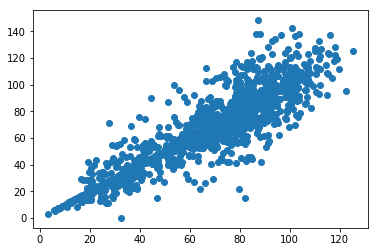

In [46]:
plt.plot(df['svr_rbf_global'], df['rGFR'],'o')
plt.show()

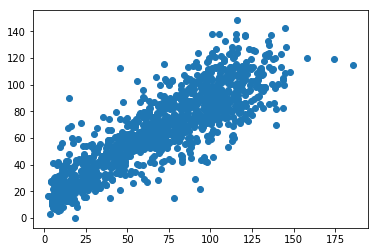

In [47]:
plt.plot(df['CKD_EPI_Cr'], df['rGFR'],'o')
plt.show()

先算了个sum可还行。现在纠正过来了。既然其实它效果已经不错了，但是再试试其他变换方法能不能更佳。首先是变换，然后是各个类别（主要是性别。那些
本身也进入连续公式算的项应该是为了分段回归压制非线性，不过我这本来就是非线性的就没必要了）分别拟合。

In [59]:
dfp = df.loc[:df.shape[0]-1] # last record is hard to deal

In [62]:
yp = np.log(dfp['rGFR'])
Xp = np.stack([dfp['age'], np.log(dfp['Scr']), np.log(dfp['Cys'])], 1)

In [64]:
svr_rbf_log = SVR(kernel='rbf', C=1e3, gamma=0.1)

In [65]:
%time
y_rbf_log = svr_rbf_log.fit(Xp, yp).predict(Xp)

In [69]:
np.mean((np.exp(y_rbf_log) - dfp['rGFR'])**2)

162.78740655225513

162对181，效果稍微好一些。所以下面仍然会使用此变换，反正数据是一样的（除了要idxs index外）。下面把先把sex直接加进来（作为某种虚拟变量）
回归，以及分别回归（使用两套系数）。

In [77]:
yp = np.log(dfp['rGFR'])
Xp_sex = np.stack([dfp['age'], np.log(dfp['Scr']), np.log(dfp['Cys']), dfp['sex']], 1)

In [78]:
svr_rbf_log_sex = SVR(kernel='rbf', C=1e3, gamma=0.1)

In [82]:
%%time
y_rbf_log_sex = svr_rbf_log_sex.fit(Xp_sex, yp).predict(Xp_sex)

Wall time: 8.25 s


In [83]:
np.mean((np.exp(y_rbf_log_sex) - dfp['rGFR'])**2)

130.00215220997177

130对162，仅仅作为数值虚拟变量就能极大的改善估计。下面试试使用两套系数再合起来的方法。

In [85]:
dfp_women = dfp[dfp['sex'] == 2]
yp_women = np.log(dfp_women['rGFR'])
Xp_sex_women = np.stack([dfp_women['age'], np.log(dfp_women['Scr']), np.log(dfp_women['Cys']), dfp_women['sex']], 1)

dfp_men = dfp[dfp['sex'] == 1]
yp_men = np.log(dfp_men['rGFR'])
Xp_sex_men = np.stack([dfp_men['age'], np.log(dfp_men['Scr']), np.log(dfp_men['Cys']), dfp_men['sex']], 1)

In [86]:
%%time
y_rbf_log_sex_women = svr_rbf_log_sex.fit(Xp_sex_women, yp_women).predict(Xp_sex_women)
y_rbf_log_sex_men = svr_rbf_log_sex.fit(Xp_sex_men, yp_men).predict(Xp_sex_men)


Wall time: 3.24 s


In [89]:
len(y_rbf_log_sex_men)

711

In [94]:
(np.sum((np.exp(yp_women) - np.exp(y_rbf_log_sex_women))**2) + np.sum((np.exp(yp_men) - np.exp(y_rbf_log_sex_men))**2))/(len(y_rbf_log_sex_women)+len(y_rbf_log_sex_men))

126.07120422471378

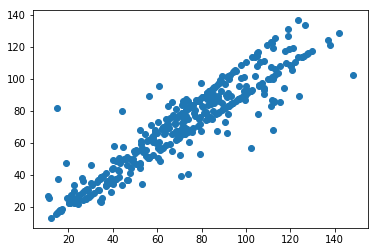

In [95]:
plt.plot(np.exp(yp_women), np.exp(y_rbf_log_sex_women), 'o')

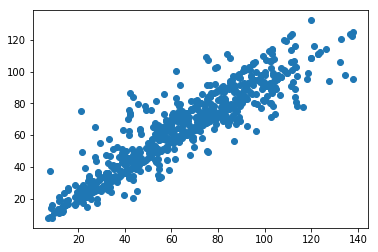

In [96]:
plt.plot(np.exp(yp_men), np.exp(y_rbf_log_sex_men), 'o')

126对130，比较用虚拟变量略有改善，要从统计观点估计就拒绝这个修改了。下面我们要打开黑箱，重现这个结果。

In [97]:
#svr_rbf_log_sex.predict??

In [99]:
#svr_rbf_log_sex._dense_predict??

In [109]:
svr_rbf_log_sex.dual_coef_.shape

(1, 472)

这就是SVR的系数了，怎么用的暂时不管，反正也没法写成简洁的形式。472个呢。SVM也是训练集全体投票（投票权重在训练时决定，
然后预测时还要算相似度，最后决定结果。）.下面条调调C和gamma,epsilon 三个参数。

gamma : float, optional (default=’auto’)
Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.

Current default is ‘auto’ which uses 1 / n_features, if gamma='scale' is passed then it uses 1 / (n_features * X.std()) as value of gamma. The current default of gamma, ‘auto’, will change to ‘scale’ in version 0.22. ‘auto_deprecated’, a deprecated version of ‘auto’ is used as a default indicating that no explicit value of gamma was passed.

C : float, optional (default=1.0)
Penalty parameter C of the error term.

epsilon : float, optional (default=0.1)
Epsilon in the epsilon-SVR model. It specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value.



In [111]:
mat = np.empty([3,3,3])
for i,gamma in enumerate([0.05,0.1,0.15]):
    for j,C in enumerate([500,1e3,1500]):
        for k,epsilon in enumerate([0.05,0.1,0.15]):
            svr_rbf_log_sex_test = SVR(kernel='rbf', C=C, gamma=gamma, epsilon=epsilon)
            y_rbf_log_sex_test = svr_rbf_log_sex_test.fit(Xp_sex, yp).predict(Xp_sex)
            loss = np.mean((np.exp(y_rbf_log_sex_test) - dfp['rGFR'])**2)
            print(gamma,C,epsilon,loss)
            mat[i,j,k] = loss

0.05 500 0.05 163.5014691717553
0.05 500 0.1 160.74954942498226
0.05 500 0.15 165.11851481919567
0.05 1000.0 0.05 158.57043750068104
0.05 1000.0 0.1 156.9389731744231
0.05 1000.0 0.15 161.80194896071185
0.05 1500 0.05 155.91019535658953
0.05 1500 0.1 155.0960083981905
0.05 1500 0.15 159.7594070253459
0.1 500 0.05 135.07693385998786
0.1 500 0.1 135.78478707756474
0.1 500 0.15 143.89118422502185
0.1 1000.0 0.05 127.75251284409454
0.1 1000.0 0.1 130.00215220997177
0.1 1000.0 0.15 139.75886340110495
0.1 1500 0.05 123.57858467128501
0.1 1500 0.1 125.4467938601781
0.1 1500 0.15 138.0304615593653
0.15 500 0.05 108.86390690514874
0.15 500 0.1 112.98069315939864
0.15 500 0.15 128.04854800263504
0.15 1000.0 0.05 101.73182859782712
0.15 1000.0 0.1 108.5984201354754
0.15 1000.0 0.15 124.61831373148719
0.15 1500 0.05 97.86829456754356
0.15 1500 0.1 105.25699503485419
0.15 1500 0.15 121.11443685186188


0.15 500 0.05 108.86390690514874
0.15 1000.0 0.05 101.73182859782712
0.15 1000.0 0.1 108.5984201354754
0.15 1500 0.05 97.86829456754356
0.15 1500 0.1 105.25699503485419

几个参数比较好，可以看出全是0.15，500，1000，1500不定,0.05或0.1较好。所以接下来取
`[0.125,0.15,0.175],[500,1000,1500],[0.05,0.075,0.01]`

In [117]:
mat2 = np.empty([3,3,3])
for i,gamma in enumerate([0.125,0.15,0.175]):
    for j,C in enumerate([500,1000,1500]):
        for k,epsilon in enumerate([0.05,0.075,0.1]):
            svr_rbf_log_sex_test = SVR(kernel='rbf', C=C, gamma=gamma, epsilon=epsilon)
            y_rbf_log_sex_test = svr_rbf_log_sex_test.fit(Xp_sex, yp).predict(Xp_sex)
            loss = np.mean((np.exp(y_rbf_log_sex_test) - dfp['rGFR'])**2)
            print(gamma,C,epsilon,loss)
            mat2[i,j,k] = loss

0.125 500 0.05 120.80409948739032
0.125 500 0.075 121.22817051083581
0.125 500 0.1 122.97060684005577
0.125 1000 0.05 113.73906001662814
0.125 1000 0.075 114.33935255147907
0.125 1000 0.1 117.47037204088446
0.125 1500 0.05 108.36317004208134
0.125 1500 0.075 109.95028143790405
0.125 1500 0.1 113.19806063064705
0.15 500 0.05 108.86390690514874
0.15 500 0.075 110.29891879135492
0.15 500 0.1 112.98069315939864
0.15 1000 0.05 101.73182859782712
0.15 1000 0.075 103.61304023626111
0.15 1000 0.1 108.5984201354754
0.15 1500 0.05 97.86829456754356
0.15 1500 0.075 100.00629826610317
0.15 1500 0.1 105.25699503485419
0.175 500 0.05 100.67034111212213
0.175 500 0.075 102.61176982452078
0.175 500 0.1 106.86623335352171
0.175 1000 0.05 93.94897104474906
0.175 1000 0.075 95.8871588852174
0.175 1000 0.1 101.25178266026693
0.175 1500 0.05 90.04858625120885
0.175 1500 0.075 92.95609511188381
0.175 1500 0.1 98.1649643119023


In [118]:
np.min(mat2)

90.04858625120885

较优的有：
```
0.15 1500 0.05 97.86829456754356
0.175 1000 0.05 93.94897104474906
0.175 1000 0.075 95.8871588852174
0.175 1500 0.05 90.04858625120885
0.175 1500 0.075 92.95609511188381
0.175 1500 0.1 98.1649643119023
```

In [119]:
mat3 = np.empty([3,3,3])
for i,gamma in enumerate([0.15,0.175,0.2]):
    for j,C in enumerate([1000,1500,2000]):
        for k,epsilon in enumerate([0.025,0.05,0.075]):
            svr_rbf_log_sex_test = SVR(kernel='rbf', C=C, gamma=gamma, epsilon=epsilon)
            y_rbf_log_sex_test = svr_rbf_log_sex_test.fit(Xp_sex, yp).predict(Xp_sex)
            loss = np.mean((np.exp(y_rbf_log_sex_test) - dfp['rGFR'])**2)
            print(gamma,C,epsilon,loss)
            mat3[i,j,k] = loss

0.15 1000 0.025 103.85545083449827
0.15 1000 0.05 101.73182859782712
0.15 1000 0.075 103.61304023626111
0.15 1500 0.025 99.82415798934058
0.15 1500 0.05 97.86829456754356
0.15 1500 0.075 100.00629826610317
0.15 2000 0.025 96.82249880078206
0.15 2000 0.05 94.96218222084713
0.15 2000 0.075 97.55295387671178
0.175 1000 0.025 95.74443139621047
0.175 1000 0.05 93.94897104474906
0.175 1000 0.075 95.8871588852174
0.175 1500 0.025 90.96168922834703
0.175 1500 0.05 90.04858625120885
0.175 1500 0.075 92.95609511188381
0.175 2000 0.025 87.87493439293708
0.175 2000 0.05 87.89998861162947
0.175 2000 0.075 91.20761749901841
0.2 1000 0.025 87.70479193511187
0.2 1000 0.05 87.48482817314043
0.2 1000 0.075 90.7057131053799
0.2 1500 0.025 84.77761397479415
0.2 1500 0.05 84.60985893231353
0.2 1500 0.075 88.16413370561965
0.2 2000 0.025 82.76195138947976
0.2 2000 0.05 82.63466644214309
0.2 2000 0.075 85.92742542015087


话说回来这是train集上测train集的性能，感觉有误导性。。虽然SVM相对不容易overfit一点。根据
https://datascience.stackexchange.com/questions/26640/how-to-check-for-overfitting-with-svm-and-iris-data
进行交叉验证吧。

In [121]:
from sklearn.model_selection import train_test_split


In [122]:
X_train, X_test, y_train, y_test = train_test_split(Xp_sex, yp, test_size=0.2, random_state=51)

In [124]:
mat = np.empty([3,3,3,2])
for i,gamma in enumerate([0.05,0.1,0.15]):
    for j,C in enumerate([500,1e3,1500]):
        for k,epsilon in enumerate([0.05,0.1,0.15]):
            svr_rbf_log_sex_test = SVR(kernel='rbf', C=C, gamma=gamma, epsilon=epsilon)
            svr_rbf_log_sex_test.fit(X_train, y_train)
            
            y_train_pred = svr_rbf_log_sex_test.predict(X_train)
            y_test_pred =  svr_rbf_log_sex_test.predict(X_test)
            
            train_loss = np.mean((np.exp(y_train) - np.exp(y_train_pred))**2)
            test_loss = np.mean((np.exp(y_test) - np.exp(y_test_pred))**2)
            
            print('gamma = {} C = {} epsilon = {} train loss ={} test loss = {}'.format(gamma, C, epsilon, train_loss, test_loss))
            mat[i,j,k,0] = train_loss
            mat[i,j,k,1] = test_loss

gamma = 0.05 C = 500 epsilon = 0.05 train loss =153.096491622681 test loss = 282.3586892331305
gamma = 0.05 C = 500 epsilon = 0.1 train loss =150.66079135899145 test loss = 265.7422410806212
gamma = 0.05 C = 500 epsilon = 0.15 train loss =153.6824096509939 test loss = 308.0053957206774
gamma = 0.05 C = 1000.0 epsilon = 0.05 train loss =146.37234550793264 test loss = 314.3566946761014
gamma = 0.05 C = 1000.0 epsilon = 0.1 train loss =145.9940950372049 test loss = 298.78647989193576
gamma = 0.05 C = 1000.0 epsilon = 0.15 train loss =150.75674101860525 test loss = 324.29180415093515
gamma = 0.05 C = 1500 epsilon = 0.05 train loss =142.46273094321245 test loss = 327.9664699966334
gamma = 0.05 C = 1500 epsilon = 0.1 train loss =142.98368529434268 test loss = 330.68238998963716
gamma = 0.05 C = 1500 epsilon = 0.15 train loss =147.72123009611317 test loss = 349.80456938635194
gamma = 0.1 C = 500 epsilon = 0.05 train loss =122.10574251945994 test loss = 370.2185494331943
gamma = 0.1 C = 500 ep

In [160]:
sortidx = np.argsort(mat[:,:,:,0].flatten())

Text(0,0.5,'test loss')

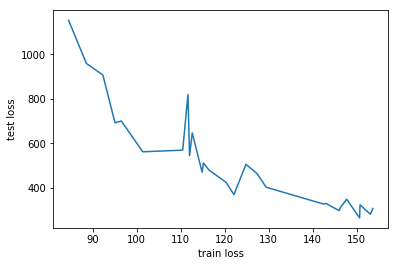

In [163]:
plt.plot(mat[:,:,:,0].flatten()[sortidx], mat[:,:,:,1].flatten()[sortidx])
plt.xlabel('train loss')
plt.ylabel('test loss')
#plt.legend()

果然。。取到最小train loss的反而取到了最大的test loss.test上性能比较好的有：

```
gamma = 0.05 C = 500 epsilon = 0.05 train loss =153.096491622681 test loss = 282.3586892331305
gamma = 0.05 C = 500 epsilon = 0.1 train loss =150.66079135899145 test loss = 265.7422410806212
gamma = 0.05 C = 500 epsilon = 0.15 train loss =153.6824096509939 test loss = 308.0053957206774
gamma = 0.05 C = 1000.0 epsilon = 0.05 train loss =146.37234550793264 test loss = 314.3566946761014
gamma = 0.05 C = 1000.0 epsilon = 0.1 train loss =145.9940950372049 test loss = 298.78647989193576
```

In [125]:
mat2 = np.empty([3,3,3,2])
for i,gamma in enumerate([0.025,0.05,0.075]):
    for j,C in enumerate([500,750,1000]):
        for k,epsilon in enumerate([0.05,0.1,0.15]):
            svr_rbf_log_sex_test = SVR(kernel='rbf', C=C, gamma=gamma, epsilon=epsilon)
            svr_rbf_log_sex_test.fit(X_train, y_train)
            
            y_train_pred = svr_rbf_log_sex_test.predict(X_train)
            y_test_pred =  svr_rbf_log_sex_test.predict(X_test)
            
            train_loss = np.mean((np.exp(y_train) - np.exp(y_train_pred))**2)
            test_loss = np.mean((np.exp(y_test) - np.exp(y_test_pred))**2)
            
            print('gamma = {} C = {} epsilon = {} train loss ={} test loss = {}'.format(gamma, C, epsilon, train_loss, test_loss))
            mat2[i,j,k,0] = train_loss
            mat2[i,j,k,1] = test_loss

gamma = 0.025 C = 500 epsilon = 0.05 train loss =166.05505990007327 test loss = 266.7965528280521
gamma = 0.025 C = 500 epsilon = 0.1 train loss =167.18276718581097 test loss = 262.5433988082249
gamma = 0.025 C = 500 epsilon = 0.15 train loss =169.45713940312336 test loss = 280.2704167195471
gamma = 0.025 C = 750 epsilon = 0.05 train loss =164.83471127029975 test loss = 269.3317144813987
gamma = 0.025 C = 750 epsilon = 0.1 train loss =164.17954655751467 test loss = 258.9617448446673
gamma = 0.025 C = 750 epsilon = 0.15 train loss =167.29561757289366 test loss = 288.3668473369197
gamma = 0.025 C = 1000 epsilon = 0.05 train loss =163.88356502900155 test loss = 273.8345647241228
gamma = 0.025 C = 1000 epsilon = 0.1 train loss =162.86666352165636 test loss = 260.327989804144
gamma = 0.025 C = 1000 epsilon = 0.15 train loss =166.11343739540368 test loss = 300.32502697128615
gamma = 0.05 C = 500 epsilon = 0.05 train loss =153.096491622681 test loss = 282.3586892331305
gamma = 0.05 C = 500 ep

较好的有：
```
gamma = 0.025 C = 500 epsilon = 0.05 train loss =166.05505990007327 test loss = 266.7965528280521
gamma = 0.025 C = 500 epsilon = 0.1 train loss =167.18276718581097 test loss = 262.5433988082249
gamma = 0.025 C = 500 epsilon = 0.15 train loss =169.45713940312336 test loss = 280.2704167195471
gamma = 0.025 C = 750 epsilon = 0.05 train loss =164.83471127029975 test loss = 269.3317144813987
gamma = 0.025 C = 750 epsilon = 0.1 train loss =164.17954655751467 test loss = 258.9617448446673
gamma = 0.025 C = 750 epsilon = 0.15 train loss =167.29561757289366 test loss = 288.3668473369197
gamma = 0.025 C = 1000 epsilon = 0.05 train loss =163.88356502900155 test loss = 273.8345647241228
gamma = 0.025 C = 1000 epsilon = 0.1 train loss =162.86666352165636 test loss = 260.327989804144


```

In [126]:
mat3 = np.empty([3,3,3,2])
for i,gamma in enumerate([0.01,0.02,0.03]):
    for j,C in enumerate([500,750,1000]):
        for k,epsilon in enumerate([0.05,0.1,0.15]):
            svr_rbf_log_sex_test = SVR(kernel='rbf', C=C, gamma=gamma, epsilon=epsilon)
            svr_rbf_log_sex_test.fit(X_train, y_train)
            
            y_train_pred = svr_rbf_log_sex_test.predict(X_train)
            y_test_pred =  svr_rbf_log_sex_test.predict(X_test)
            
            train_loss = np.mean((np.exp(y_train) - np.exp(y_train_pred))**2)
            test_loss = np.mean((np.exp(y_test) - np.exp(y_test_pred))**2)
            
            print('gamma = {} C = {} epsilon = {} train loss ={} test loss = {}'.format(gamma, C, epsilon, train_loss, test_loss))
            mat3[i,j,k,0] = train_loss
            mat3[i,j,k,1] = test_loss

gamma = 0.01 C = 500 epsilon = 0.05 train loss =180.17825427221157 test loss = 232.00717211523087
gamma = 0.01 C = 500 epsilon = 0.1 train loss =180.85186327008236 test loss = 227.57426091857405
gamma = 0.01 C = 500 epsilon = 0.15 train loss =184.18292397496376 test loss = 246.35023471073538
gamma = 0.01 C = 750 epsilon = 0.05 train loss =179.47504865529598 test loss = 234.97247568937246
gamma = 0.01 C = 750 epsilon = 0.1 train loss =179.86769513040133 test loss = 239.19992039435
gamma = 0.01 C = 750 epsilon = 0.15 train loss =183.62881055972002 test loss = 246.9774236221409
gamma = 0.01 C = 1000 epsilon = 0.05 train loss =179.1473574527548 test loss = 239.49373932422864
gamma = 0.01 C = 1000 epsilon = 0.1 train loss =179.4918766036786 test loss = 238.23628041064643
gamma = 0.01 C = 1000 epsilon = 0.15 train loss =183.4440631531235 test loss = 243.92260204997064
gamma = 0.02 C = 500 epsilon = 0.05 train loss =170.45765146355913 test loss = 261.4882662516275
gamma = 0.02 C = 500 epsilon

In [137]:
mat3 = np.empty([3,3,3,2])
for i,gamma in enumerate([0.00001,0.006,0.012]):
    for j,C in enumerate([500,750,1000]):
        for k,epsilon in enumerate([0.05,0.1,0.15]):
            svr_rbf_log_sex_test = SVR(kernel='rbf', C=C, gamma=gamma, epsilon=epsilon)
            svr_rbf_log_sex_test.fit(X_train, y_train)
            
            y_train_pred = svr_rbf_log_sex_test.predict(X_train)
            y_test_pred =  svr_rbf_log_sex_test.predict(X_test)
            
            train_loss = np.mean((np.exp(y_train) - np.exp(y_train_pred))**2)
            test_loss = np.mean((np.exp(y_test) - np.exp(y_test_pred))**2)
            
            print('gamma = {} C = {} epsilon = {} train loss ={} test loss = {}'.format(gamma, C, epsilon, train_loss, test_loss))
            mat3[i,j,k,0] = train_loss
            mat3[i,j,k,1] = test_loss

gamma = 1e-05 C = 500 epsilon = 0.05 train loss =220.25862392549925 test loss = 235.70605465401366
gamma = 1e-05 C = 500 epsilon = 0.1 train loss =222.34303088314402 test loss = 235.91230280294025
gamma = 1e-05 C = 500 epsilon = 0.15 train loss =223.8469953353611 test loss = 240.37356100183362
gamma = 1e-05 C = 750 epsilon = 0.05 train loss =221.506441151234 test loss = 239.31414840580604
gamma = 1e-05 C = 750 epsilon = 0.1 train loss =222.93595516590003 test loss = 239.8876070575355
gamma = 1e-05 C = 750 epsilon = 0.15 train loss =224.8203336341143 test loss = 244.49970543501462
gamma = 1e-05 C = 1000 epsilon = 0.05 train loss =222.69561599272598 test loss = 241.57670922725515
gamma = 1e-05 C = 1000 epsilon = 0.1 train loss =224.18494657063394 test loss = 241.09887219440802
gamma = 1e-05 C = 1000 epsilon = 0.15 train loss =225.41599126244216 test loss = 245.6426390454773
gamma = 0.006 C = 500 epsilon = 0.05 train loss =185.90000408538026 test loss = 224.8084074575614
gamma = 0.006 C =

话说我回来我一直追逐test loss最小化不也是在过拟合么。。

```
gamma = 0.006 C = 500 epsilon = 0.1 train loss =186.26345065222927 test loss = 212.12341586377866
gamma = 0.006 C = 750 epsilon = 0.1 train loss =184.8625276435058 test loss = 214.58529940469526
gamma = 0.006 C = 1000 epsilon = 0.1 train loss =184.10491329793376 test loss = 215.82467504344532
```

In [132]:
1/(X_train.std()*4) # auto也就应该得到这个数，确实应该取到比较小。

0.010019060118527096

In [141]:
mat3 = np.empty([3,3,3,2])
for i,gamma in enumerate([0.005,0.006,0.007]):
    for j,C in enumerate([250, 500,750]):
        for k,epsilon in enumerate([0.075,0.1,0.125]):
            svr_rbf_log_sex_test = SVR(kernel='rbf', C=C, gamma=gamma, epsilon=epsilon)
            svr_rbf_log_sex_test.fit(X_train, y_train)
            
            y_train_pred = svr_rbf_log_sex_test.predict(X_train)
            y_test_pred =  svr_rbf_log_sex_test.predict(X_test)
            
            train_loss = np.mean((np.exp(y_train) - np.exp(y_train_pred))**2)
            test_loss = np.mean((np.exp(y_test) - np.exp(y_test_pred))**2)
            
            print('gamma = {} C = {} epsilon = {} train loss ={} test loss = {}'.format(gamma, C, epsilon, train_loss, test_loss))
            mat3[i,j,k,0] = train_loss
            mat3[i,j,k,1] = test_loss

gamma = 0.005 C = 250 epsilon = 0.075 train loss =189.435873288272 test loss = 221.98761506040768
gamma = 0.005 C = 250 epsilon = 0.1 train loss =191.16807045689154 test loss = 216.37856618275472
gamma = 0.005 C = 250 epsilon = 0.125 train loss =192.0713862505666 test loss = 223.89495943078825
gamma = 0.005 C = 500 epsilon = 0.075 train loss =187.19901234839824 test loss = 217.88288908376708
gamma = 0.005 C = 500 epsilon = 0.1 train loss =188.2060153006922 test loss = 218.17381413429058
gamma = 0.005 C = 500 epsilon = 0.125 train loss =189.7695261485154 test loss = 228.3536195662541
gamma = 0.005 C = 750 epsilon = 0.075 train loss =185.90919377816002 test loss = 222.8836172334892
gamma = 0.005 C = 750 epsilon = 0.1 train loss =186.85613249009472 test loss = 216.52109215466507
gamma = 0.005 C = 750 epsilon = 0.125 train loss =188.43527540113496 test loss = 232.55813353349492
gamma = 0.006 C = 250 epsilon = 0.075 train loss =187.08204079443183 test loss = 222.29211812818662
gamma = 0.006

In [143]:
svr_rbf_log_sex_test = SVR(kernel='rbf', C=500, gamma=0.006, epsilon=0.1)
svr_rbf_log_sex_test.fit(Xp_sex, yp)

yp_pred = svr_rbf_log_sex_test.predict(Xp_sex)

In [144]:
np.mean((np.exp(yp_pred) - np.exp(yp))**2)

189.64043175187462

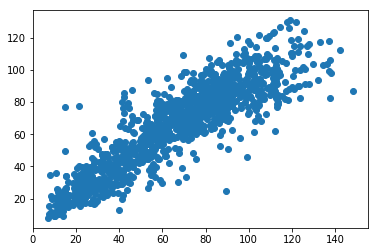

In [147]:
plt.plot(np.exp(yp), np.exp(yp_pred),'o')

In [149]:
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X, y, test_size=0.2, random_state=51)

In [151]:
mat3 = np.empty([3,3,3,2])
for i,gamma in enumerate([0.005,0.006,0.007]):
    for j,C in enumerate([250, 500,750]):
        for k,epsilon in enumerate([0.075,0.1,0.125]):
            svr_rbf_log_sex_test = SVR(kernel='rbf', C=C, gamma=gamma, epsilon=epsilon)
            svr_rbf_log_sex_test.fit(X_train_o, y_train_o)
            
            y_train_pred = svr_rbf_log_sex_test.predict(X_train_o)
            y_test_pred =  svr_rbf_log_sex_test.predict(X_test_o)
            
            train_loss = np.mean((y_train_o - y_train_pred)**2)
            test_loss = np.mean((y_test_o - y_test_pred)**2)
            
            print('gamma = {} C = {} epsilon = {} train loss ={} test loss = {}'.format(gamma, C, epsilon, train_loss, test_loss))
            mat3[i,j,k,0] = train_loss
            mat3[i,j,k,1] = test_loss

gamma = 0.005 C = 250 epsilon = 0.075 train loss =231.49164473242206 test loss = 222.3932079995614
gamma = 0.005 C = 250 epsilon = 0.1 train loss =231.49079048264247 test loss = 222.41066566609743
gamma = 0.005 C = 250 epsilon = 0.125 train loss =231.4898997980734 test loss = 222.42033167993887
gamma = 0.005 C = 500 epsilon = 0.075 train loss =225.10252465666534 test loss = 216.87784561553556
gamma = 0.005 C = 500 epsilon = 0.1 train loss =225.06691274118407 test loss = 216.8718999212315
gamma = 0.005 C = 500 epsilon = 0.125 train loss =225.00168094659313 test loss = 216.8801954252076
gamma = 0.005 C = 750 epsilon = 0.075 train loss =221.7692298689632 test loss = 213.54663605918702
gamma = 0.005 C = 750 epsilon = 0.1 train loss =221.76029283907354 test loss = 213.66565482157492
gamma = 0.005 C = 750 epsilon = 0.125 train loss =221.76548300469932 test loss = 213.76477918698558
gamma = 0.006 C = 250 epsilon = 0.075 train loss =227.8189864621852 test loss = 220.50886123220292
gamma = 0.00

gamma = 0.006 C = 750 epsilon = 0.075 train loss =218.136646817429 test loss = 209.99392847722712

不用变换效果更好可还行，不过下面这些估计有点对测试集过拟合了。可以看到train loss 比test loss还大

In [152]:
svr_rbf_log_sex_test = SVR(kernel='rbf', C=500, gamma=0.006, epsilon=0.1)
svr_rbf_log_sex_test.fit(X, y)

y_pred = svr_rbf_log_sex_test.predict(X)

In [153]:
np.mean((y_pred - y)**2)

217.7479956770599